## Imports

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

2.5.1
True
11.8


## Load CBD dataset (for training)

### Transformation
 - resize to 244,244
 - normalized based on calculations from training set
 - converted to tensors

In [2]:
import numpy as np
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset

In [3]:

import torch
from PIL import Image
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import numpy as np

# add label map and convert labels to integers

class XMLDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, label_map=None, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.annotation_filenames = sorted(os.listdir(annotation_dir))
        self.label_map = label_map
        self.image_name = ""
        self.transform = transform
        
    def parse_xml(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        self.image_name = root.find('filename').text
        
        boxes = []
        labels = []
        areas = []
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        
        for obj in root.findall('object'):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            xwidth = xmax - xmin
            yheight = ymax - ymin
            area = xwidth*yheight
            
            areas.append(area)
            #for albumentations
            boxes.append([xmin, ymin, xmax, ymax])
            if (self.label_map):
                label_idx = self.label_map[label]
            labels.append(label_idx)
        
        return torch.tensor(boxes, dtype=torch.float32), labels, areas, width, height
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        
        try:
            # Load image
            img_path = os.path.join(self.image_dir, self.image_filenames[idx])
            image = Image.open(img_path).convert("RGB")
            
            # Load annotation
            annotation_path = os.path.join(self.annotation_dir, self.annotation_filenames[idx])
            boxes, labels, areas, width, height= self.parse_xml(annotation_path)
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': idx,
                'area': areas,
                }
            
             # Apply transformation if provided
            if self.transform:
                # Convert boxes to a format suitable for albumentations (COCO format)
                transformed_image = self.transform(image)
                
                # Update the data with the transformed image and boxes
                image = transformed_image

                
            target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)
            target['image_id'] = torch.tensor(target['labels'], dtype=torch.int64)
            target['area'] = torch.tensor(target['labels'], dtype=torch.int64)
            
            
            return (image, target)
        
        except Exception as e:
            # Print the error and the image_id that caused it
            print(f"Error loading data for image name {self.image_name}, idx {idx}")
            print(f"Error: {str(e)}")
            # You can return None or raise the error depending on your need
        return None


In [4]:
#calculation mean and std of training set for normalization

def compute_dataset_stats(image_dir):
    mean = np.zeros(3)
    std = np.zeros(3)
    total_pixels = 0

    # List all files in the directory
    image_filenames = sorted(os.listdir(image_dir))

    for img_filename in image_filenames:
        img_path = os.path.join(image_dir, img_filename)

        # Open the image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image) / 255.0  # Convert to range [0, 1]

        # Compute mean and std
        mean += image.mean(axis=(0, 1))
        std += image.std(axis=(0, 1))
        total_pixels += 1

    # Compute average mean and std across all images
    mean /= total_pixels
    std /= total_pixels
    return mean.tolist(), std.tolist()

# Example usage
# image_dir = '/kaggle/input/dataset/dataset/train_img'
image_dir = '../dataset/train_img'
mean, std = compute_dataset_stats(image_dir)
print("Mean:", mean)
print("Std:", std)


Mean: [0.9362358181861065, 0.9420508144749817, 0.9394349808120092]
Std: [0.16755679634617304, 0.15510376581525342, 0.1576581799256157]


In [5]:
from torchvision.transforms import v2

#apply transformations to image and bounding boxes

transform = v2.Compose([
    #scales and converst to float32 tensors
    v2.ToTensor()
    ])



c:\Users\Lee Le Xuan\anaconda3\envs\ComputerVision2\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
label_map = {
    "text" : 1,
    "arrow" : 2,
    "connection" : 3,
    "data": 4,
    "decision": 5,
    "process" : 6,
    "terminator" : 7
}

# train = XMLDataset(image_dir='/kaggle/input/dataset/dataset/train_img', annotation_dir='/kaggle/input/dataset/dataset/xml_files/train', label_map=label_map, transform=transform)
# test = XMLDataset(image_dir='/kaggle/input/dataset/dataset/test_img', annotation_dir='/kaggle/input/dataset/dataset/xml_files/test', label_map=label_map, transform=transform)
# validation = XMLDataset(image_dir='/kaggle/input/dataset/dataset/val_img', annotation_dir='/kaggle/input/dataset/dataset/xml_files/val', label_map=label_map, transform=transform)
train = XMLDataset(image_dir='../dataset/train_img', annotation_dir='../dataset/xml_files/train', label_map=label_map, transform=transform)
test = XMLDataset(image_dir='../dataset/test_img', annotation_dir='../dataset/xml_files/test', label_map=label_map, transform=transform)
validation = XMLDataset(image_dir='../dataset/val_img', annotation_dir='../dataset/xml_files/val', label_map=label_map, transform=transform)

data = train[0]
print(data)

(tensor([[[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490]],

        [[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490]],

        [[0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
         [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0

C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['image_id'] = torch.tensor(target['labels'], dtype=torch.int64)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['area'] = torch.tensor(target['labels

In [7]:
# assert data['objects']['bbox'][0].tolist() == [201., 31., 211., 92.], "First box coordinates do not match"
(image, target) = data
# assert target['labels'][:5] == [7, 6, 6, 6, 5], "First five labels do not match"
assert len(target['area']) == len(target['labels']), "Length of area and category do not match"
assert len(target['boxes']) == len(target['area']), "Length of bbox and area do not match"
# print("new image size", image.shape)



print("Assertions passed successfully!")

Assertions passed successfully!


## Load FCA dataset (for testing)

## Load Inception ResNet


In [8]:
import timm
from collections import OrderedDict
import torch.nn as nn

device = 'cuda'

inception_resnet = timm.create_model(
    'inception_resnet_v2.tf_ens_adv_in1k',
    pretrained=True,
    features_only=True,
)

o = inception_resnet(torch.randn(2, 3, 229, 229))
for x in o:
    print(x.shape)


class CustomInceptionResnetBackbone(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        # Forward pass through the backbone
        out = self.backbone(x)
        
        
        # for i in range(len(out)):
        #     in_channel = list(out[i].shape)[1]
        #     conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1).to(device)
        #     feature_dict[str(i)] = conv(out[i])
        
        # only want last feature map 
        return out[-1]
# Create the custom backbone with the permute operation
inception_resnet_backbone = CustomInceptionResnetBackbone(inception_resnet).to(device)
print(inception_resnet_backbone)

c:\Users\Lee Le Xuan\anaconda3\envs\ComputerVision2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 64, 112, 112])
torch.Size([2, 192, 53, 53])
torch.Size([2, 320, 26, 26])
torch.Size([2, 1088, 12, 12])
torch.Size([2, 1536, 5, 5])
CustomInceptionResnetBackbone(
  (backbone): FeatureListNet(
    (conv2d_1a): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2d_2a): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2d_2b): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
 

In [9]:

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision

inception_resnet_backbone.out_channels = 1536
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), 
    aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"], 
    output_size = 7, 
    sampling_ratio=2
    )

model = FasterRCNN(
    backbone=inception_resnet_backbone,
    #7 + 1 for background
    num_classes=299,
    # min_size=256,
    max_size=299,
    image_mean=mean,
    image_std=std,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler)

# model = torch.nn.DataParallel(model).to(device)
# model.to(device)

In [10]:
print(mean, std)

[0.9362358181861065, 0.9420508144749817, 0.9394349808120092] [0.16755679634617304, 0.15510376581525342, 0.1576581799256157]


In [11]:
from torch.utils.data import DataLoader, Subset
from torch.utils.data.dataloader import default_collate

# train on the GPU or on the CPU, if a GPU is not available
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    collated = []
    for item in batch:
        images = item[0]
        labels = item[1]
        images = images.to(device)
        for key, value in labels.items():
            if torch.is_tensor(value):
                labels[key] = value.to(device) 

        collated.append((images, labels))

    return tuple(zip(*collated))
         
train_subset = Subset(train, list(range(12)))
val_subset = Subset(validation, list(range(8)))

# define training and validation data loaders
data_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


In [12]:
# params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.AdamW(params, lr=0.00005,  weight_decay=0.01)

# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )

from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Warmup scheduler (first 5 epochs)
warmup_scheduler = LinearLR(optimizer, start_factor=1e-6, total_iters=5)

# Main scheduler (after warmup)
main_scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Combine the warmup and main scheduler
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[5])


In [13]:
#edited from pytorch documentation
def train_one_epoch(model, optimizer, data_loader,  epoch):
    try: 
        model.train()
        header = f"Epoch: [{epoch}]"
        total_loss = 0
        avg_loss = 0
        last_loss = 0
        loss_dict = {}
        
        for i, data in enumerate(data_loader):
            images, labels = data
            
            loss_dict = model(images, labels)
            # print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())


            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            # Gather data and report
            total_loss += losses.item()
            
            last_loss = losses.item()
            print(header)
            print('  batch {} loss: {}'.format(i + 1, last_loss))
        batch_size = len(data_loader)
        avg_loss = total_loss/batch_size
            
        print(loss_dict)
            
    except Exception as e:
        # Print the error and the image_id that caused it
        # print(f"Error for image name {labels['image_id']}")
        # print(data)
        print(f"Error: {str(e)}")
        # You can return None or raise the error depending on your need
        raise e
        
    return last_loss, avg_loss



In [14]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [15]:
# !pip install pycocotools
# !pip install faster-coco-eval
# !pip install torchmetrics[detection]

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime
import torchvision
from torchmetrics.detection.mean_ap import MeanAveragePrecision

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.0

# move model to cuda
model.to(device)
model.backbone.to(device) 
# model.backbone = torch.nn.DataParallel(model.backbone, device_ids = [0,1]).to(device)

print(device)
for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    last_loss, avg_loss = train_one_epoch(
        epoch=epoch_number,
        model=model,
        data_loader=data_loader,
        optimizer=optimizer
    )

    scheduler.step()

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    total_map = 0
    total_map_per_class = torch.zeros(7)

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        total_predictions = 0
        correct_predictions = 0

        for i, vdata in enumerate(data_loader_val):
            vinputs, vlabels = vdata  # Images and their ground-truth labels

            # Compute the model outputs and loss
            loss_dict, detections = eval_forward(model, vinputs, vlabels)  # Pass inputs and targets
            # print(detections)
            # print(loss_dict)
            vloss = sum(loss for loss in loss_dict.values())
            running_vloss += vloss.item()

            metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True)
            metric.update(detections, vlabels)
            map_dict = metric.compute()
            print(map_dict)
            total_map += map_dict["map"]
            map_per_class = map_dict["map_per_class"]
            classes = map_dict["classes"]
            
            for index, value in zip(classes, map_per_class):
                if value >= 0:
                    total_map_per_class[index-1] += value
            

        avg_vloss = running_vloss / (i + 1)
        avg_map = total_map/ (i+1)
        avg_map_per_class = total_map_per_class / (i+1)
        
        print("////////////////////////////////////////////////////////////////////////////////")
        print(f"LOSS train avg: {avg_loss}, last: {last_loss} valid {avg_vloss}")
        print(f"MAP: {avg_map}")
        print(f"map per class: {avg_map_per_class}")
        

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

cuda
EPOCH 1:


C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['image_id'] = torch.tensor(target['labels'], dtype=torch.int64)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['area'] = torch.tensor(target['labels

Epoch: [0]
  batch 1 loss: 6.607445240020752
Epoch: [0]
  batch 2 loss: 6.550203323364258
Epoch: [0]
  batch 3 loss: 6.549647808074951
{'loss_classifier': tensor(5.6336, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0668, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7111, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1383, device='cuda:0', grad_fn=<DivBackward0>)}
{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'mar_100_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'classes': tensor([1, 2, 4, 5, 6, 7], dtype=torch.int32)}
{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small':

c:\Users\Lee Le Xuan\anaconda3\envs\ComputerVision2\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'mar_100_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'classes': tensor([1, 2, 4, 5, 6, 7], dtype=torch.int32)}
{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'mar_100_per_class': tensor([0., 0., 0., 0., 0., 0.]), 'classes': tensor([1, 2, 4, 5, 6, 7], dtype=torch.int32)}
////////////////////////////////////////////////////////////////////////////////
LOSS train avg: 2.8

C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['image_id'] = torch.tensor(target['labels'], dtype=torch.int64)
C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_21240\1211123672.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['area'] = torch.tensor(target['labels

{'boxes': tensor([[6.1402e+02, 5.4564e+02, 7.1403e+02, 5.7973e+02],
        [3.9681e+02, 5.4036e+02, 5.6346e+02, 6.1270e+02],
        [6.4495e+02, 5.4972e+02, 6.8810e+02, 5.7354e+02],
        [2.6653e+02, 1.6850e+02, 6.7179e+02, 8.1171e+02],
        [4.6540e+02, 1.3172e+02, 8.6358e+02, 8.4196e+02],
        [7.3394e+02, 3.2975e+02, 8.3982e+02, 3.6459e+02],
        [6.9228e+02, 3.0033e+02, 8.5937e+02, 3.9042e+02],
        [5.9551e+02, 3.4853e+02, 7.8019e+02, 6.9015e+02],
        [6.0475e+02, 1.1657e+02, 8.3474e+02, 2.0799e+02],
        [3.4429e+02, 6.4079e+01, 5.9121e+02, 1.8607e+02],
        [6.2486e+02, 1.4044e+02, 7.5928e+02, 2.4569e+02],
        [5.2883e+02, 8.9478e+01, 8.0237e+02, 2.2340e+02],
        [4.1983e+02, 3.3723e+02, 6.1210e+02, 7.1653e+02],
        [6.1714e+02, 2.9746e+02, 8.1559e+02, 3.8839e+02],
        [5.6774e+02, 2.4489e+02, 8.3176e+02, 4.4703e+02],
        [3.1375e+02, 1.6700e+02, 9.9391e+02, 6.7414e+02],
        [4.0288e+02, 0.0000e+00, 8.1734e+02, 4.8975e+02],
    

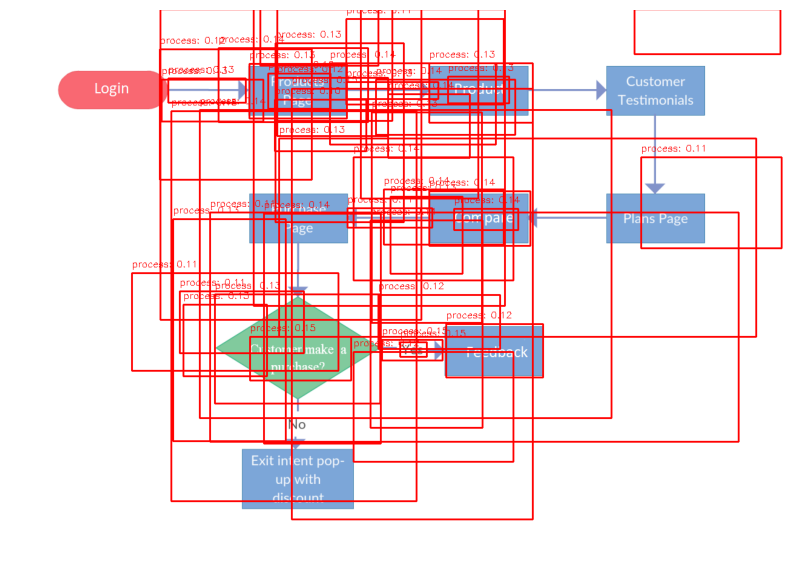

{'boxes': tensor([[ 807.8183,  508.8651, 1048.2733,  608.1574],
        [ 629.8128,  627.7538,  938.7764,  759.9495],
        [ 772.1617,  572.1850, 1125.1172,  624.3159],
        [ 395.2592,  649.4960,  708.8486,  775.8217],
        [ 843.8946,  588.3624, 1109.7383,  792.5230],
        [ 379.8123,  701.9368,  602.0822,  833.7370],
        [ 310.7561,  621.1205,  720.4337,  900.9794],
        [ 608.1475,  639.7400,  730.7788,  668.4330],
        [ 343.2140,  561.5811,  598.8276,  954.2820],
        [ 729.3168,  529.5112, 1172.1609,  783.2409],
        [ 596.9357,  653.4915,  956.3501,  882.8252],
        [ 788.3474,  649.0925, 1113.4065,  874.4697],
        [ 361.1986,  472.8387, 1210.5397,  963.6876],
        [ 292.3928,  450.9793,  319.9629,  532.3531],
        [ 884.5859,  497.5307, 1132.8542,  899.6351],
        [ 290.4641, 1090.1582,  317.1935, 1177.5684],
        [ 815.9967,  401.4426, 1142.2872,  614.7459],
        [ 620.2393,  501.1107,  850.3031,  626.0180],
        [ 215.5450

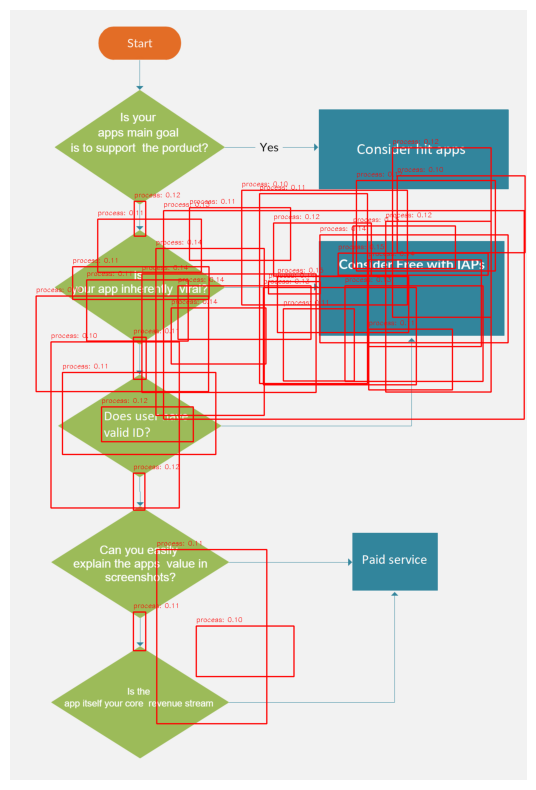

In [22]:
import cv2
import matplotlib.pyplot as plt

def draw_predictions(image, prediction, label_map, score_threshold=0.5):
    """
    Draw predicted bounding boxes on the image.

    Args:
        image (numpy array): The input image as a NumPy array (e.g., from cv2.imread).
        prediction (list of dict): Predictions containing 'boxes', 'labels', and 'scores'.
        label_map (dict): A dictionary mapping label indices to class names.
        score_threshold (float): Minimum confidence score to display a prediction.

    Returns:
        numpy array: The image with bounding boxes drawn.
    """
    # Create a copy of the image for drawing
    img_with_boxes = image.copy()

    # Iterate through each prediction in the list

    boxes = prediction['boxes'].detach().cpu().numpy()  # Convert to NumPy
    labels = prediction['labels'].detach().cpu().numpy()  # Convert to NumPy
    scores = prediction['scores'].detach().cpu().numpy()  # Convert to NumPy

    # Filter predictions based on the score threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= score_threshold:
            # Get bounding box coordinates
            x_min, y_min, x_max, y_max = box.astype(int)
            color = (0, 255, 0)  # Green for bounding boxes

            if label == 2:
                # Draw rectangle on the image
                color = (0, 255, 0)  # Green for bounding boxes
            if label == 6:
                # Draw rectangle on the image
                color = (255, 0, 0)  # red for bounding boxes
            if label == 1:
                # Draw rectangle on the image
                color = (0, 0, 255)  # blue for bounding boxes
            
            cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), color, thickness=2)
            
            # Add label and score
            text = f"{label_map[label]}: {score:.2f}"
            cv2.putText(
                img_with_boxes, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, color=color, thickness=1
            )

    return img_with_boxes

# Define a label map for class labels
label_map = {1: "text", #blue
             2: "arrow", #green
             3: "connection",
             4: "data",
             5: "decision",
             6: "process", #red
             7: "terminator"}

# Example usage
# Replace 'your_image.jpg' with the path to your image

for i, vdata in enumerate(data_loader_val):
    vinputs, vlabels = vdata  # Images and their ground-truth labels
    # Compute the model outputs and loss
    loss_dict, detections = eval_forward(model, vinputs, vlabels)  # Pass inputs and targets
    image = vinputs[0].cpu().permute(1, 2, 0).numpy()  # Change dimension order
    image = (image * 255).astype(np.uint8)
    print(detections[0])

    # Draw predictions
    image_with_boxes = draw_predictions(image, detections[0], label_map, score_threshold=0.1)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.show()
    break


for i, vdata in enumerate(data_loader):
    vinputs, vlabels = vdata  # Images and their ground-truth labels
    # Compute the model outputs and loss
    loss_dict, detections = eval_forward(model, vinputs, vlabels)  # Pass inputs and targets
    image = vinputs[0].cpu().permute(1, 2, 0).numpy()  # Change dimension order
    image = (image * 255).astype(np.uint8)
    print(detections[0])

    # Draw predictions
    image_with_boxes = draw_predictions(image, detections[0], label_map, score_threshold=0.1)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.show()
    break
